* This notebook contains code on how to implement logistic regression without using built in functions and also looks at various model evaluation metrics for classification models
* Note: My goal is just to explore logistic regression and not to build the best model

In [97]:
# Import all the required libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from numpy.linalg import inv
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import classification_report

In [95]:
# Import the dataset
# This is a pilot dataset which contains 1972 ebay auctions  
# Our goal is to predict whether the auction is competitive or not
df=pd.read_csv('eBayAuctions.csv')
# Display top 5 records
df.head()

,Category,currency,sellerRating,Duration,endDay,ClosePrice,OpenPrice,Competitive?
0,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
1,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
2,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
3,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0
4,Music/Movie/Game,US,3249,5,Mon,0.01,0.01,0


In [3]:
# Check if there are any null values in the dataframe
df.isnull().any()
# There are no null values in the data as shown below

Category        False
currency        False
sellerRating    False
Duration        False
endDay          False
ClosePrice      False
OpenPrice       False
Competitive?    False
dtype: bool

In [4]:
# Cross check the data types of all the columns before modeling
df.dtypes
# 'Category','currency', 'endDay' and 'Competitive?' need to be changed to categorical

Category         object
currency         object
sellerRating      int64
Duration          int64
endDay           object
ClosePrice      float64
OpenPrice       float64
Competitive?      int64
dtype: object

In [5]:
# Change the data types of the categorical variables accordingly
df.Category=df.Category.astype('category')
df.currency=df.currency.astype('category')
df.endDay=df.endDay.astype('category')
df['Competitive?']=df['Competitive?'].astype('category')

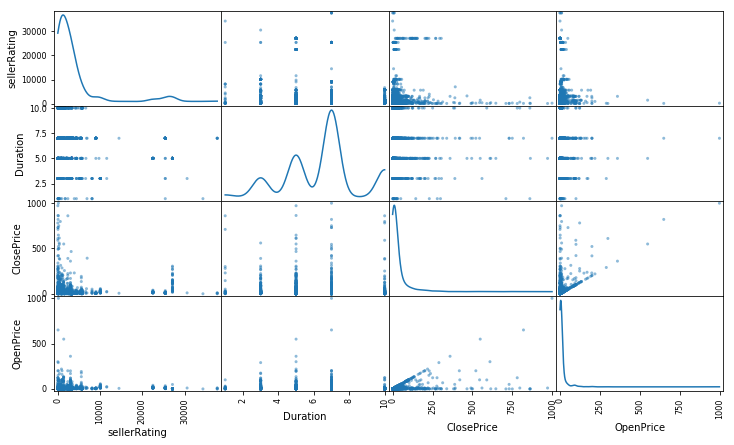

In [6]:
# Scatter plot of all the variables, open price and close price look correlated
plt=scatter_matrix(df,diagonal='kde',figsize=(12,7))

In [7]:
# Split the whole data into X and Y sets
df_Y=df['Competitive?']
df_X=df.drop('Competitive?',axis=1)

In [8]:
# Generate dummy values of the categorical variables and drop one (i.e. n-1 dummies for n categories)
df_dummies=pd.get_dummies(df_X,drop_first=True)
df_dummies.insert(0,'Intercept',[1]*len(df_dummies))
# Display top 5 records
df_dummies.head()

,Intercept,sellerRating,Duration,ClosePrice,OpenPrice,Category_Automotive,Category_Books,Category_Business/Industrial,Category_Clothing/Accessories,Category_Coins/Stamps,...,Category_SportingGoods,Category_Toys/Hobbies,currency_GBP,currency_US,endDay_Mon,endDay_Sat,endDay_Sun,endDay_Thu,endDay_Tue,endDay_Wed
0,1,3249,5,0.01,0.01,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,1,3249,5,0.01,0.01,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,1,3249,5,0.01,0.01,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,1,3249,5,0.01,0.01,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,1,3249,5,0.01,0.01,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [9]:
# Splitting data into 70:30 train:test ratio
X_train,X_test,Y_train,Y_test=train_test_split(df_dummies,df_Y,test_size=0.3,random_state=33)

In [96]:
# Changing the index of the records to sequential
X_train.index=range(len(X_train))
Y_train.index=range(len(Y_train))
X_test.index=range(len(X_test))
Y_test.index=range(len(Y_test))

#### Logistic Regression from Scratch

In [30]:
# Convert X and Y train sets to matrices
X=np.array(X_train)
Y=np.array(Y_train)

In [31]:
# Calculate coefficients from (XT.X)-1.XT.Y
coefficients=inv(X.transpose().dot(X)).dot(X.transpose()).dot(Y)
# Coefficients from the equation
coefficients

array([  6.17695814e-01,  -9.64449154e-06,  -1.26210148e-02,
         1.50460507e-03,  -2.84002872e-03,  -1.68306118e-01,
        -2.39991092e-02,   9.81091700e-02,  -1.00762478e-01,
        -3.05157579e-01,   2.97869333e-02,   3.28021155e-02,
         1.15369574e-01,  -3.81853726e-01,  -4.21625012e-01,
         3.22141897e-02,  -1.33695646e-01,  -4.11695215e-02,
         8.79316038e-02,  -1.22139431e-01,   1.09930411e-01,
        -4.62338496e-03,   3.20796806e-01,   1.01578421e-02,
         1.99532590e-01,  -6.67132440e-02,   1.79853599e-02,
        -7.22726623e-02,   9.60017475e-02,   2.08644745e-02])

In [54]:
# Probability predictions from the equation
predictions=X.dot(inv(X.transpose().dot(X)).dot(X.transpose()).dot(Y))
predictions=np.exp(predictions)/(1+np.exp(predictions))
predictions

array([ 0.67618342,  0.58955049,  0.67788777, ...,  0.67683326,
        0.61407099,  0.61557691])

#### glm model

In [53]:
# fit glm model
model_lg=sm.GLM(Y_train,X_train)
model_lg=model_lg.fit()
# Intercept and coefficients from glm
model_lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           Competitive?   No. Observations:                 1380
Model:                            GLM   Df Residuals:                     1350
Model Family:                Gaussian   Df Model:                           29
Link Function:               identity   Scale:                  0.207815964196
Method:                          IRLS   Log-Likelihood:                -858.91
Date:                Fri, 02 Mar 2018   Deviance:                       280.55
Time:                        08:23:15   Pearson chi2:                     281.
No. Iterations:                     2                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.6177      0.085      7.251      0.000       0.451       0.785
sellerRating                  -9.644e-06   2.49e-06     -3.878      0.000   -1.45e-05   -4.77e-06
Duration                         -0.0126      0.008     -1.669      0.095      -0.027       0.002
ClosePrice                        0.0015      0.000      8.805      0.000       0.001       0.002
OpenPrice                        -0.0028      0.000     -5.702      0.000      -0.004      -0.002
Category_Automotive              -0.1683      0.065     -2.570      0.010      -0.297      -0.040
Category_Books                   -0.0240      0.088     -0.272      0.785      -0.197       0.149
Category_Business/Industrial      0.0981      0.127      0.773      0.439      -0.151       0.347
Category_Clothing/Accessories    -0.1008      0.071     -1.427      0.154      -0.239       0.038
Category_Coins/Stamps            -0.3052      0.101     -3.008      0.003      -0.504      -0.106
Category_Collectibles             0.0298      0.056      0.532      0.595      -0.080       0.140
Category_Computer                 0.0328      0.101      0.324      0.746      -0.166       0.231
Category_Electronics              0.1154      0.092      1.255      0.210      -0.065       0.296
Category_EverythingElse          -0.3819      0.134     -2.857      0.004      -0.644      -0.120
Category_Health/Beauty           -0.4216      0.079     -5.349      0.000      -0.576      -0.267
Category_Home/Garden              0.0322      0.073      0.442      0.659      -0.111       0.175
Category_Jewelry                 -0.1337      0.079     -1.702      0.089      -0.288       0.020
Category_Music/Movie/Game        -0.0412      0.051     -0.804      0.422      -0.142       0.059
Category_Photography              0.0879      0.153      0.575      0.565      -0.212       0.388
Category_Pottery/Glass           -0.1221      0.142     -0.859      0.390      -0.401       0.157
Category_SportingGoods            0.1099      0.069      1.594      0.111      -0.025       0.245
Category_Toys/Hobbies            -0.0046      0.058     -0.080      0.936      -0.118       0.108
currency_GBP                      0.3208      0.086      3.727      0.000       0.152       0.490
currency_US                       0.0102      0.040      0.256      0.798      -0.068       0.088
endDay_Mon                        0.1995      0.043      4.679      0.000       0.116       0.283
endDay_Sat                       -0.0667      0.046     -1.440      0.150      -0.158       0.024
endDay_Sun                        0.0180      0.047      0.380      0.704      -0.075       0.111
endDay_Thu                       -0.0723      0.082     -0.886      0.376      -0.232       0.088
endDay_Tue                        0.0960      0.057      1.697      0.090      -0.015       0.207
endDay_Wed                

In [52]:
# Coefficients from both the models
allcoeficients=pd.DataFrame({'Equation':coefficients,'Glm':model_lg.params},index=model_lg.params.index)
allcoeficients

,Equation,Glm
Intercept,0.617696,0.617696
sellerRating,-0.000010,-0.000010
Duration,-0.012621,-0.012621
ClosePrice,0.001505,0.001505
OpenPrice,-0.002840,-0.002840
Category_Automotive,-0.168306,-0.168306
Category_Books,-0.023999,-0.023999
Category_Business/Industrial,0.098109,0.098109
Category_Clothing/Accessories,-0.100762,-0.100762
Category_Coins/Stamps,-0.305158,-0.305158


In [37]:
# Compare output predictions of equation and glm
def getResponses(probabilities):
    responses=[]
    for i in range(len(probabilities)):
        if probabilities[i]<0.5:
            responses.append(0)
        else:
            responses.append(1)
    return responses
getResponses(predictions)==getResponses(np.exp(model_lg.predict())/(1+np.exp(model_lg.predict())))
# Both the predictions are equal as shown below

True

### Model Diagonosis

1. Confusion matrix

In [38]:
# Response prediction of X_test
testPredictions=X_test.dot(coefficients)
testPredictions=np.exp(testPredictions)/(1+np.exp(testPredictions))
testPredictions=getResponses(testPredictions)

In [62]:
# Confusion matrix
tn,fp,fn,tp=confusion_matrix(Y_test,testPredictions).ravel()
tn,fp,fn,tp

(3, 295, 1, 293)

In [67]:
# Sensitivity
sensitivity=tp/(fn+tp)
sensitivity
# Interpretation: 99.7% of the actual positives(1) are predicted correctly

0.99659863945578231

In [69]:
# Specificity
specificity=tn/(tn+fp)
specificity
# Interpretation: Of all the negatives(0) only 1% are predicted correctly - 
# which is bad and depends on our prediction goal

0.010067114093959731

In [71]:
# Precision
precision=tp/(tp+fp)
precision
# Interpretation: About 50% of the predicted positives are actually positive, which is not that good

0.49829931972789115

In [72]:
# Recall==sensitivity
sensitivity

0.99659863945578231

In [77]:
# Accuracy and misclassfication rate
misclassification=1-accuracy
accuracy=(tp+tn)/(tp+fn+fp+tn)
print('misclassification: {}, accuracy: {}'.format(misclassification,accuracy))
# Accuracy is only 50%.Hence the model is not even better than a random guess

misclassification: 0.5, accuracy: 0.5


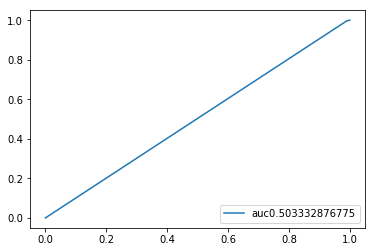

In [91]:
# ROC curve
fpr,tpr,thresholds=roc_curve(Y_test,testPredictions)
auc=roc_auc_score(Y_test,testPredictions)
auc
plt.plot(fpr,tpr,label='auc'+str(auc))
plt.legend(loc=4)
plt.show()
# It is a very bad roc

In [93]:
# Pseudo R2 - McFadden R2
McFaddenR= 1- (model_lg.llf/model_lg.llnull)
McFaddenR
# Higher the value of McFadden R2 better is the model. Here the value is not high, hence the model is not good

0.13397012758849569

In [100]:
# Precision and recall from builtin function
print(classification_report(Y_test,testPredictions))

             precision    recall  f1-score   support

          0       0.75      0.01      0.02       298
          1       0.50      1.00      0.66       294

avg / total       0.62      0.50      0.34       592

